<a href="https://colab.research.google.com/github/omarFarooq21/Miscellanous/blob/main/DL4NLP_Homework_3_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment analysis with RNNs**

In this task, you will implement LSTM architectures with PyTorch to perform a sentiment analysis for movie reviews.


## Download the required datasets

Executing this cell will download all the records needed to work on the homework

In [1]:
# Download glove
!wget https://github.com/uclnlp/inferbeddings/raw/master/data/glove/glove.6B.50d.txt.gz
!gzip -f -d glove.6B.50d.txt.gz

# install datasets from huggingface
!pip install datasets

--2024-06-24 22:04:02--  https://github.com/uclnlp/inferbeddings/raw/master/data/glove/glove.6B.50d.txt.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/uclnlp/inferbeddings/master/data/glove/glove.6B.50d.txt.gz [following]
--2024-06-24 22:04:02--  https://raw.githubusercontent.com/uclnlp/inferbeddings/master/data/glove/glove.6B.50d.txt.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67967602 (65M) [application/octet-stream]
Saving to: ‘glove.6B.50d.txt.gz’

glove.6B.50d.txt.gz 100%[===================>]  64.82M  85.4MB/s    in 0.8s    

2024-06-24 22:04:03 (85.4 MB/s) - ‘glove.6B.50d.txt.g

## Use the GPU for computations if possible

In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


## Library Imports

In [3]:
import torch.nn as nn
import os
import re
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset
from collections import defaultdict
from sklearn.metrics import f1_score
from datasets import load_dataset
from tqdm import tqdm
import torch.optim as optim

In [4]:
# Specify random seed
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Set random seeds; do not change this!
seed_everything(seed=42)

## **Task 1 [6P]: Data sets and pretrained Embeddings**

In the first cell you've downloaded (!wget ...) the uncased GloVe embeddings with 6B tokens [glove.6B.zip](https://nlp.stanford.edu/projects/glove/) from Stanford. For performance reasons, we will only use the 50-dimensional embeddings **glove.6B.50d.txt**.

a) [2P] Implement a function to read the embeddings.

In [5]:
def read_embeddings(embedding_path):
    embeddings = defaultdict(list)
    with open(embedding_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = [float(val) for val in values[1:]]
            embeddings[word] = vector
    return embeddings

embeddings_path = "glove.6B.50d.txt"
embeddings = read_embeddings(embeddings_path)
print(len(embeddings), len(embeddings['word']))
# embeddings['word']

400000 50


b) [2P] Implement a function, which receives a tokenized word list (e.g. a sentence) and returns the embedded word list as a torch.tensor. Don't forget to handle words without corresponding embedding. In that case you can return a randomly initialized embedding or the zero-embedding (list with 50 zeros). Use your previously defined method "read_embeddings" get the embeddings from the "glove.6B.50d.txt"-textfile.

In [6]:
embeddings_path = "glove.6B.50d.txt"
embeddings = read_embeddings(embeddings_path)
def embed_data(sentence): #Receives an array of tokens
    # print(f'sentences: {sentences}')
    embedding_dim = 50  # Dimension of GloVe-Embedding
    embedded_words = []

    for word in sentence:
      if word in embeddings:
        embedded_words.append(embeddings[word])
      else:
        embedded_words.append(np.zeros(embedding_dim))

    embedded_tensor = torch.tensor(embedded_words, dtype=torch.float)
    return embedded_tensor


    embedded_tensor = torch.tensor(np.sum(embedded_words, axis=0), dtype=torch.float)
    print(embedded_tensor.shape)
    return embedded_tensor



c) [1P] Implement a `split_string` function which tokenizes a text of multiple sentences. It should take a string as input and return a list of tokens. Each token is separated by an empty space ' '. Make sure to remove "." and "," beforehand and return all tokens in lowercase.

In [7]:
def split_string(text):
    text = text.replace('.', '').replace(',', '')

    text = text.lower()
    tokens = text.split()

    return tokens


d) [1P] Load the IMDB-Reviews dataset "stanfordnlp/imdb" using the `load_dasetset`-function that is imported above. Shuffle the dataset with `seed=42` after loading. Use only the first `2500` entries of the training und testing-datasets!

In [8]:
dataset = load_dataset("imdb")
dataset = dataset.shuffle(seed=42)

train_dataset = dataset['train'].select(range(2500))
test_dataset = dataset['test'].select(range(2500))

train_dataset[3]['label']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

1

Execute the following cell to transfer the dataset to a pytorch dataloader. If the following `code breaks`, reconsider your solution of the previous task.

In [9]:
class IMDBDataset(Dataset):
    def __init__(self, dataset, device):
        self.labels = torch.tensor(dataset["label"], device=device)
        self.lengths = []
        self.data = []
        # i = 0
        for text in tqdm(dataset["text"]):
          # print(f'text: {text}')
          tokens = split_string(text)
          # print(f'tokens: {len(tokens)}')
          embeddings = embed_data(tokens)
          # print(f'embdding shape: {embeddings.size()}')
          self.data.append(embeddings.to(device))
          self.lengths.append(len(embeddings))
          # i += 1
          # if(i > 1):
          #   break


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        embeddings = self.data[idx]
        label = self.labels[idx]
        length = self.lengths[idx]


        return embeddings, length, label

def create_dataloader(dataset, device, batch_size=1, shuffle=True):
    imdb_dataset = IMDBDataset(dataset, device)
    dataloader = DataLoader(imdb_dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

In [10]:
print("Create dataloader for training")
train_dataloader = create_dataloader(train_dataset, device, 1)

print("Create dataloader for testing")
test_dataloader = create_dataloader(test_dataset, device, 1)

Create dataloader for training


  0%|          | 0/2500 [00:00<?, ?it/s]<ipython-input-6-1a6d94490dba>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  embedded_tensor = torch.tensor(embedded_words, dtype=torch.float)
100%|██████████| 2500/2500 [00:03<00:00, 681.00it/s]


Create dataloader for testing


100%|██████████| 2500/2500 [00:04<00:00, 513.02it/s]


# **Task 2 [5P]: LSTM Model**

a) [3P] We will use PyTorch to build our LSTM. Remember that the label of a review can be 0 and 1, the model should therefore return a value between 0 and 1 as it's final output, which then can be mapped to either 0 or 1 as the final label, depending on what label number the output is closer to.  
The LSTM will be **unidirectional**. The model will have the following components:
1. A single [LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) layer, which takes the embeddings as input and has a 100 dimensional hidden size.
3. A linear layer with input size of 100 and output size of the number of labels
4. A [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) activation function

Note:  
You should use the method-parameters from the __init__ method to specify layer sizes. Concrete dimension numbers will be assigned in part b)


In [43]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.LSTM = nn.LSTM(input_size, hidden_size, num_layers= 1, batch_first=True) #[:, -1, :]
        self.fully_connected_layer = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_word_embedding):
        # [ToDo]
        # hidden_0 = torch.zeros(1, input_word_embedding.size(0), self.hidden_size).to(input_word_embedding.device)
        # cell_0 = torch.zeros(1, input_word_embedding.size(0), self.hidden_size).to(input_word_embedding.device)
        output, _ = self.LSTM(input_word_embedding)
        #print(output.shape)
        LL_output = self.fully_connected_layer(output[:, -1, :])
        sigmoid_output = self.sigmoid(LL_output)
        print(f'sigmoid-shape: {sigmoid_output.shape}')
        return sigmoid_output


b) [2P] Initialize the previously defined LSTM model.

In [44]:
input_size = 50
hidden_size = 100
output_size = 1 #equal to the number of labels

lstm = LSTM(input_size, hidden_size, output_size)
lstm.to(device)


LSTM(
  (LSTM): LSTM(50, 100, batch_first=True)
  (fully_connected_layer): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

# **Task 3 [11P]: Training an LSTM-Model**
In the following exercise you will train the LSTM model.

**Hint**: you can check out this [link](https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop) to get to know more about how to train a model with pytorch. Also remember the following architecture from the lecture when handling the model output and computing the loss:
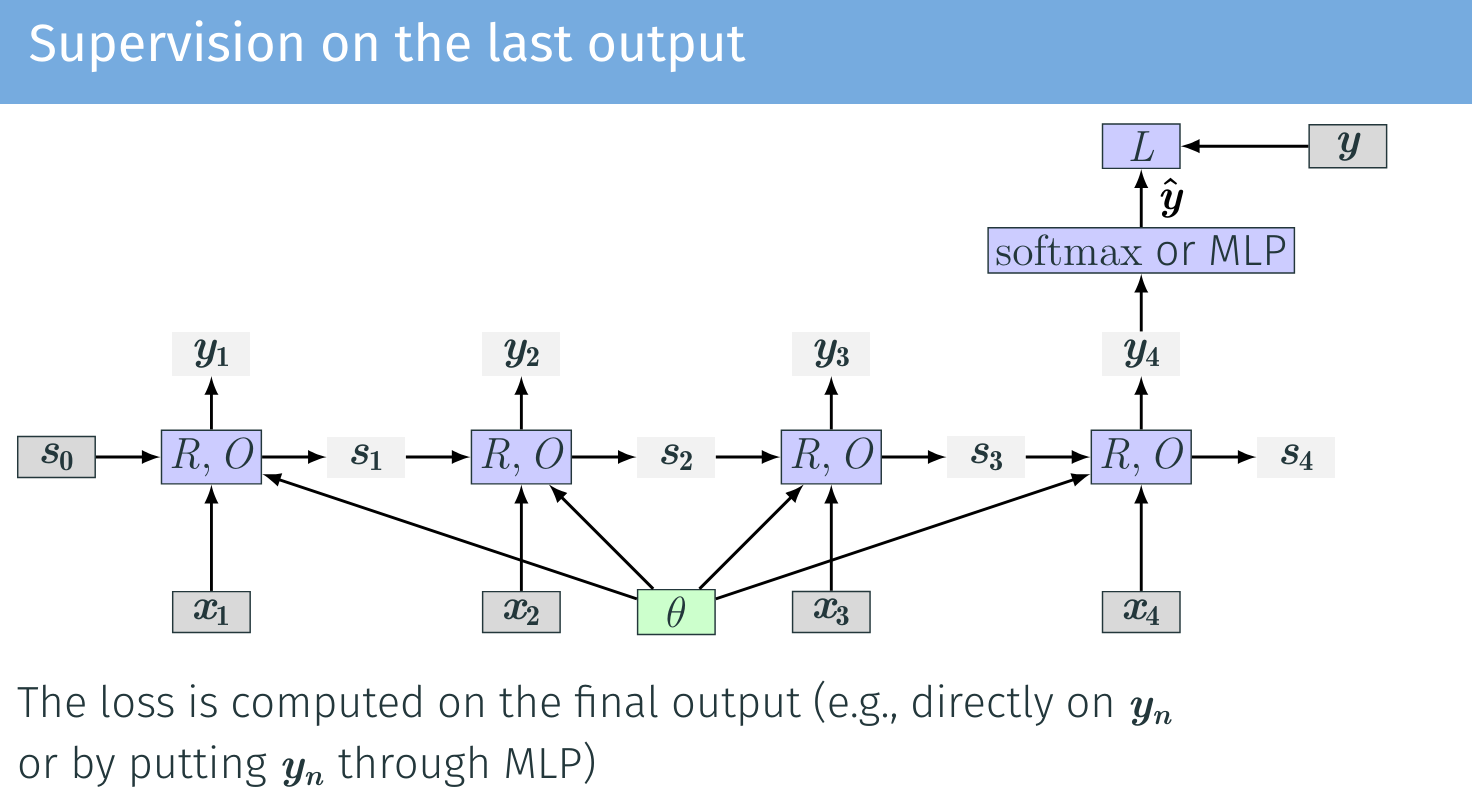



a) [1P] Initialize the loss function, optimizer and and epoch number for the upcoming training process. Use the Binary Cross Entropy loss and the Adam Optimizer with a learn rate of 0.0007 and an epoch number of 15.


In [45]:
# [ToDo]
loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.0007)
epochs = 15

b) [7.5P] Complete the function `train` to train your model. The model will train with all samples in each epoch and batch size of 1 (each review is a sample). You will train the model with the train dataset and use the test dataset to check the model's performance after each epoch. Calculate the macro f1 score of the model on the test dataset. Return the train losses and f1 scores for plotting.

For the f1 score you can use `sklearn.metrics.f1_score`.


Make sure to use the provided `device` variable from above to ensure that pytorch uses the GPU when training the model. This will speed up the training process. In our site it took about 3 minutes for 15 epochs.

In [46]:
def train(model, num_epochs, loss_function, optimizer, train_dataloader, test_dataloader, device):
    epoch_loss_logger = []
    epoch_f1_scores = []

    for epoch in range(num_epochs):
        model.train()
        training_loss = 0
        all_predictions = []
        all_labels = []

        print(f"\n Epoch {epoch + 1} of {num_epochs}")
        # Training
        for each_batch in train_dataloader:
            input, length, label = each_batch
            # print(f'input shape: {input.shape}')
            inputs, labels = input.to(device), label.to(device).float()
            optimizer.zero_grad()
            # print(f'inputs shape: {inputs.shape}')
            output = model(inputs)
            print(f'output shape: {output.shape}')
            pred = (output[-1] > 0.5).float()

            loss = loss_function(output[-1], labels)

            loss.backward()
            optimizer.step()

            training_loss += loss.item()

            # Accumulate preds and labels
            # print(f'pred shape: {pred.shape}, labels shape: {labels.shape}')
            all_predictions.extend(pred.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

        loss_per_epoch = training_loss / len(train_dataloader)
        epoch_loss_logger.append(loss_per_epoch)
        print(f"all_labels length: {len(all_labels)}, all_predictions length: {len(all_predictions)}")
        train_f1_score = f1_score(all_labels, all_predictions, average='macro')
        epoch_f1_scores.append(train_f1_score)
        print(f"Training Loss: {loss_per_epoch:.3f}, Training F1 Score: {train_f1_score:.3f}")
        break
        # Evaluation
        test_loss = 0
        ypreds = []
        xlabels = []
        model.eval()
        with torch.inference_mode():
            for each_batch in test_dataloader:
                inputs, lengths, labels = each_batch
                inputs, labels = inputs.to(device), labels.to(device).float()

                output = model(inputs)

                # print(f'Evaluation output shape: {output.shape}, labels shape: {labels.shape}')
                predictions = (output[-1] > 0.5).float()
                loss = loss_function(output[-1], labels)
                test_loss += loss.item()

                ypreds.extend(predictions.cpu().detach().numpy().tolist())
                xlabels.extend(labels.cpu().detach().numpy().tolist())

            av_test_loss = test_loss / len(test_dataloader)
            print(f"xlabels length: {len(xlabels)}, ypreds length: {len(ypreds)}")
            test_f1_score = f1_score(xlabels, ypreds, average='macro')
            print(f"Testing Loss: {av_test_loss:.3f}, Testing F1 Score: {test_f1_score:.3f}")

    return epoch_loss_logger, epoch_f1_scores


c) [0.5P] Use the train function to train the lstm model. Save the epoch losses and the f1 scores.

In [47]:
# [ToDo]
epoch_loss_logger, epoch_f1_scores = train(lstm, epochs, loss_func, optimizer, train_dataloader, test_dataloader, device)


 Epoch 1 of 15
sigmoid-shape: torch.Size([1, 1])
output shape: torch.Size([1, 1])
sigmoid-shape: torch.Size([1, 1])
output shape: torch.Size([1, 1])
sigmoid-shape: torch.Size([1, 1])
output shape: torch.Size([1, 1])
sigmoid-shape: torch.Size([1, 1])
output shape: torch.Size([1, 1])
sigmoid-shape: torch.Size([1, 1])
output shape: torch.Size([1, 1])
sigmoid-shape: torch.Size([1, 1])
output shape: torch.Size([1, 1])
sigmoid-shape: torch.Size([1, 1])
output shape: torch.Size([1, 1])
sigmoid-shape: torch.Size([1, 1])
output shape: torch.Size([1, 1])
sigmoid-shape: torch.Size([1, 1])
output shape: torch.Size([1, 1])
sigmoid-shape: torch.Size([1, 1])
output shape: torch.Size([1, 1])
sigmoid-shape: torch.Size([1, 1])
output shape: torch.Size([1, 1])
sigmoid-shape: torch.Size([1, 1])
output shape: torch.Size([1, 1])
sigmoid-shape: torch.Size([1, 1])
output shape: torch.Size([1, 1])
sigmoid-shape: torch.Size([1, 1])
output shape: torch.Size([1, 1])
sigmoid-shape: torch.Size([1, 1])
output shape

KeyboardInterrupt: 

d) [2P] Write a function visualize_data which plots a list of values. This can be done with mathplotlib.pyplot.Use this function to visualize the epoch losses and f1 scores from the previous subtask.

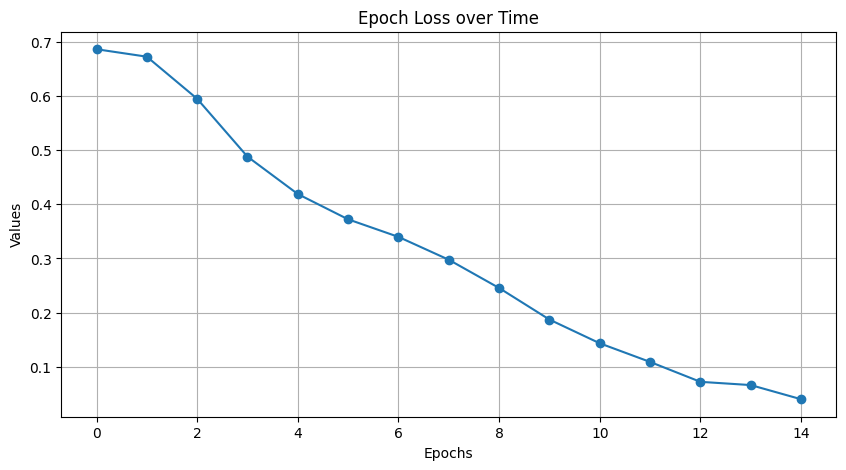

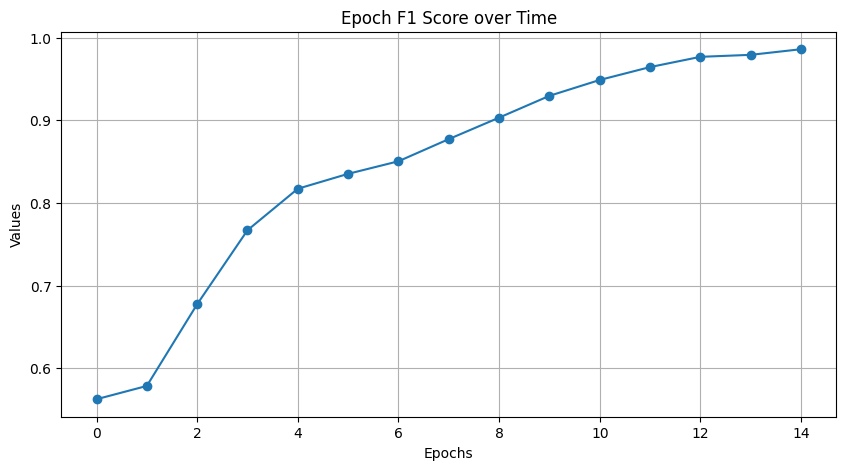

In [ ]:
def visualize_data(data, title):

    plt.figure(figsize=(10, 5))  # Größe der Figur einstellen
    plt.plot(data, marker='o', linestyle='-')  # Daten plotten mit Markierungen für Punkte und einer durchgezogenen Linie
    plt.xlabel('Epochs')  # x-Achse beschriften
    plt.ylabel('Values')  # y-Achse beschriften
    plt.title(title)  # Titel des Plots setzen
    plt.grid(True)  # Gitterlinien hinzufügen für bessere Lesbarkeit
    plt.show()  # Plot anzeigen

visualize_data(epoch_loss_logger, title='Epoch Loss over Time')
visualize_data(epoch_f1_scores, title='Epoch F1 Score over Time')

# **Task 4 [4P]: Training an RNN-Model**

In the following task you will reuse the function that you have defined to train the LSTM (from above) to evaluate it's performance compared to an RNN architecture

Here, we provide the model defintion for you.

In [ ]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)
        self.layers = nn.Sequential(nn.Linear(hidden_size, output_size),
                                    nn.Sigmoid())

    def forward(self, input_word_embedding):
        rnn_output, _ = self.rnn(input_word_embedding)
        return self.layers(rnn_output)[0]

a) [1P] Initialize the RNN-model, and prepare the loss_function and the optimizer for training. Here you should also use BCELoss and the Adam-Optimizer with a learning rate of 0.0007. We are training for 15 episodes here as well.

Use the same parameters as before.

In [ ]:
input_size = 50  # Dimension der GloVe-Einbettungen
hidden_size = 100  # Anzahl der versteckten Einheiten im RNN
output_size = 1  # Binäre Klassifikation, daher 1 Ausgabe

rnn = RNN(input_size, hidden_size, output_size)
rnn.to(device)

loss_function = nn.BCELoss()

learning_rate = 0.0007
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)



b) [0.5P] Reuse the train-function from above to train the RNN and capture the loss and f1-score

In [ ]:
epochs = 15

epoch_loss_logger, epoch_f1_scores = train(rnn, epochs, loss_function, optimizer, train_dataloader, test_dataloader, device)


 Epoch 1 of 15
all_labels length: 2500, all_predictions length: 2500
Training Loss: 0.688, Training F1 Score: 0.540
xlabels length: 2500, ypreds length: 2500
Testing Loss: 0.686, Testing F1 Score: 0.528

 Epoch 2 of 15
all_labels length: 2500, all_predictions length: 2500
Training Loss: 0.681, Training F1 Score: 0.548
xlabels length: 2500, ypreds length: 2500
Testing Loss: 0.684, Testing F1 Score: 0.560

 Epoch 3 of 15
all_labels length: 2500, all_predictions length: 2500
Training Loss: 0.677, Training F1 Score: 0.556
xlabels length: 2500, ypreds length: 2500
Testing Loss: 0.686, Testing F1 Score: 0.523

 Epoch 4 of 15
all_labels length: 2500, all_predictions length: 2500
Training Loss: 0.676, Training F1 Score: 0.567
xlabels length: 2500, ypreds length: 2500
Testing Loss: 0.683, Testing F1 Score: 0.546

 Epoch 5 of 15
all_labels length: 2500, all_predictions length: 2500
Training Loss: 0.672, Training F1 Score: 0.576
xlabels length: 2500, ypreds length: 2500
Testing Loss: 0.687, Test

c) [0.5P] For the RNN-model you should also visiualize the F1-score and the loss. You can reuse the code from above.

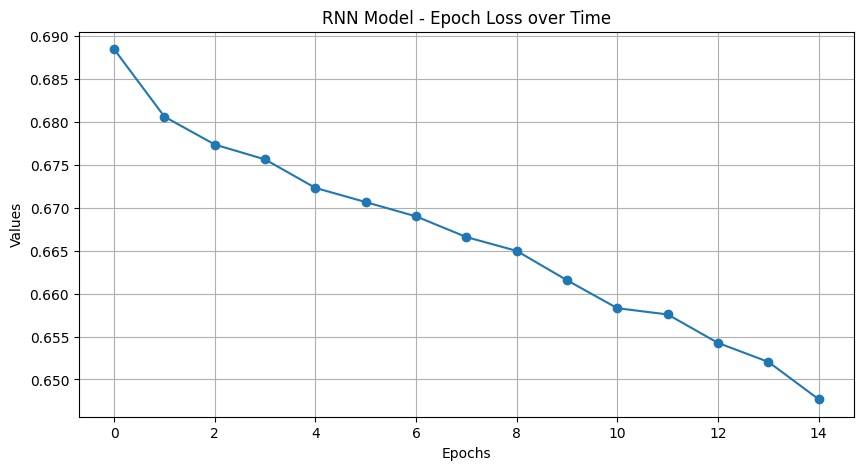

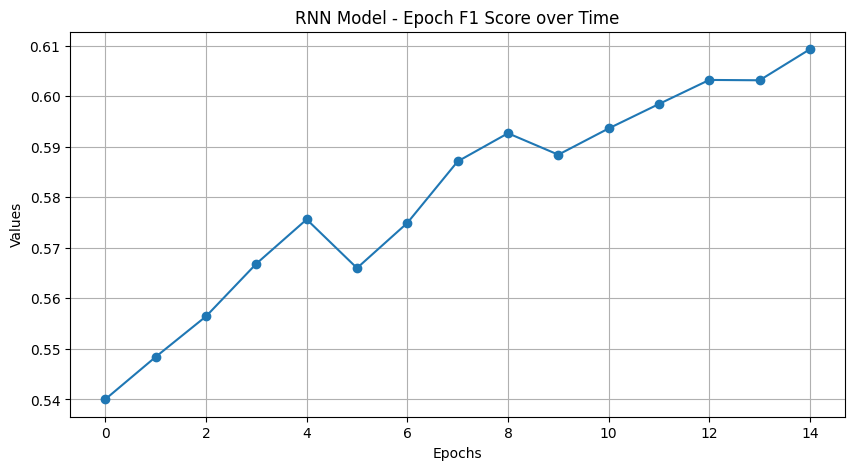

In [ ]:
visualize_data(epoch_loss_logger, title='RNN Model - Epoch Loss over Time')
visualize_data(epoch_f1_scores, title='RNN Model - Epoch F1 Score over Time')

d) [2P] Compare the training process of the RNN-Model to the LSTM-Model, what do you recognize and how can you explain these effects?

##The LSTM achieves a more stable convergence faster compared to the RNN.
## This is because LSTMs are better able to learn long-lasting dependencies in the data and avoid the vanishing gradient problem due to their architecture.